# Linear models and probabalistic programming languages

## Imports

In [30]:
%config InlineBackend.figure_format="retina"

In [65]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

## Comparing two or more groups

In [11]:
penguins = pd.read_csv(
    "https://raw.githubusercontent.com/BayesianModelingandComputationInPython"
    "/BookCode_Edition1/main/data/penguins.csv"
).dropna(subset=["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"])
summary_stats = penguins.groupby("species")["body_mass_g"].agg(["mean", "std", "count"])
summary_stats

,mean,std,count
species,,,
Adelie,3706.164384,458.620135,146
Chinstrap,3733.088235,384.335081,68
Gentoo,5092.436975,501.476154,119


Get uncertainty of above statistics

$$
\overbrace{p(\mu, \sigma \mid Y)}^{Posterior} \propto \overbrace{\mathcal{N}(Y \mid \mu, \sigma)}^{Likelihood}\;  \overbrace{\underbrace{\mathcal{N}(4000, 3000)}_{\mu}
     \underbrace{\mathcal{H}\text{T}(100, 2000)}_{\sigma}}^{Prior}
$$

In [17]:
adelie_mass_obs = penguins.loc[
    lambda df: df["species"] == "Adelie", "body_mass_g"
].to_numpy()

with pm.Model() as model_adelie_penguin_mass:
    σ = pm.HalfStudentT("σ", 100, 2_000)
    μ = pm.Normal("μ", 4_000, 3_000)
    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)

    prior = pm.sample_prior_predictive(samples=5_000)
    trace = pm.sample(chains=4)
    inf_data_adelie_penguin_mass = az.from_pymc3(prior=prior, trace=trace)

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


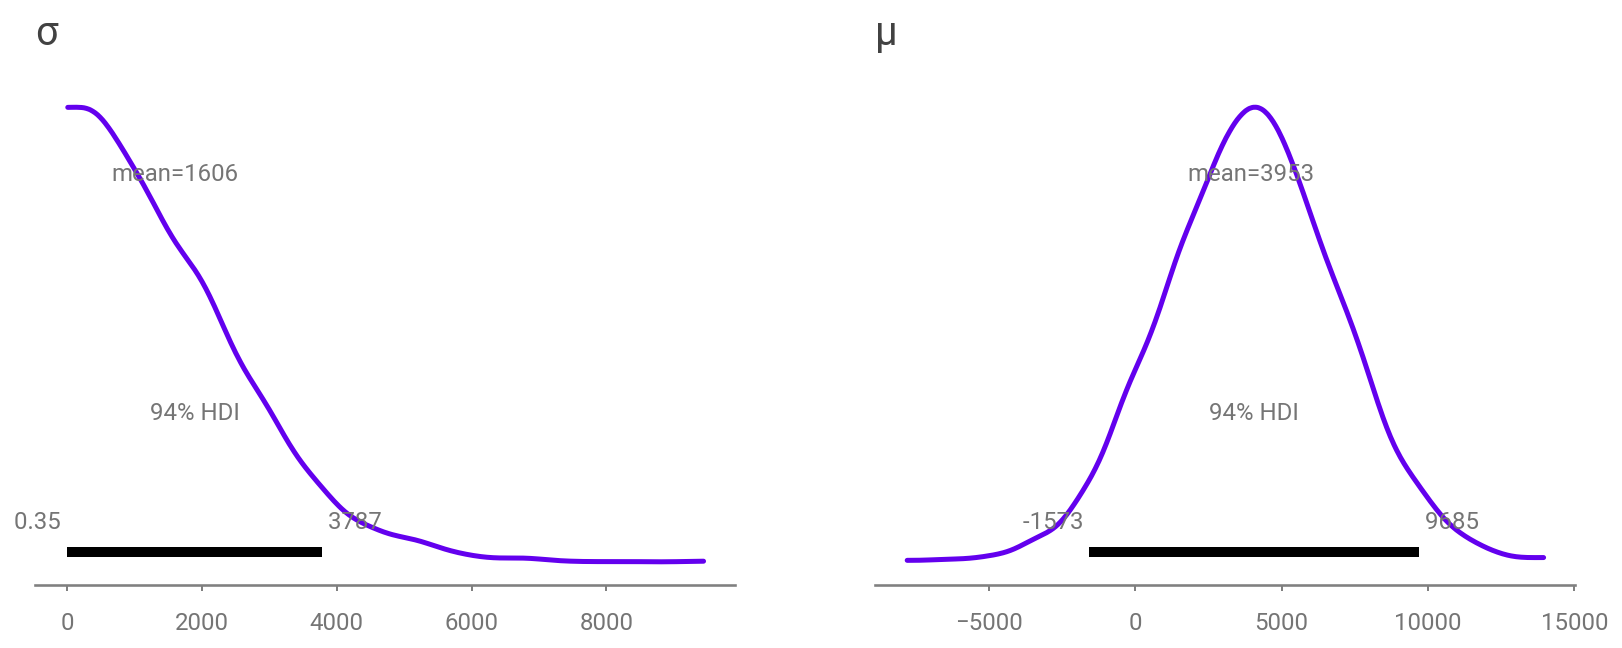

In [31]:
az.plot_posterior(inf_data_adelie_penguin_mass["prior"], var_names=["σ", "μ"]);

In [22]:
az.summary(inf_data_adelie_penguin_mass)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,3705.850,38.200,3639.920,3780.905,0.607,0.429,3962.0,2663.0,1.0
σ,462.507,27.502,413.526,515.458,0.440,0.312,3929.0,2726.0,1.0


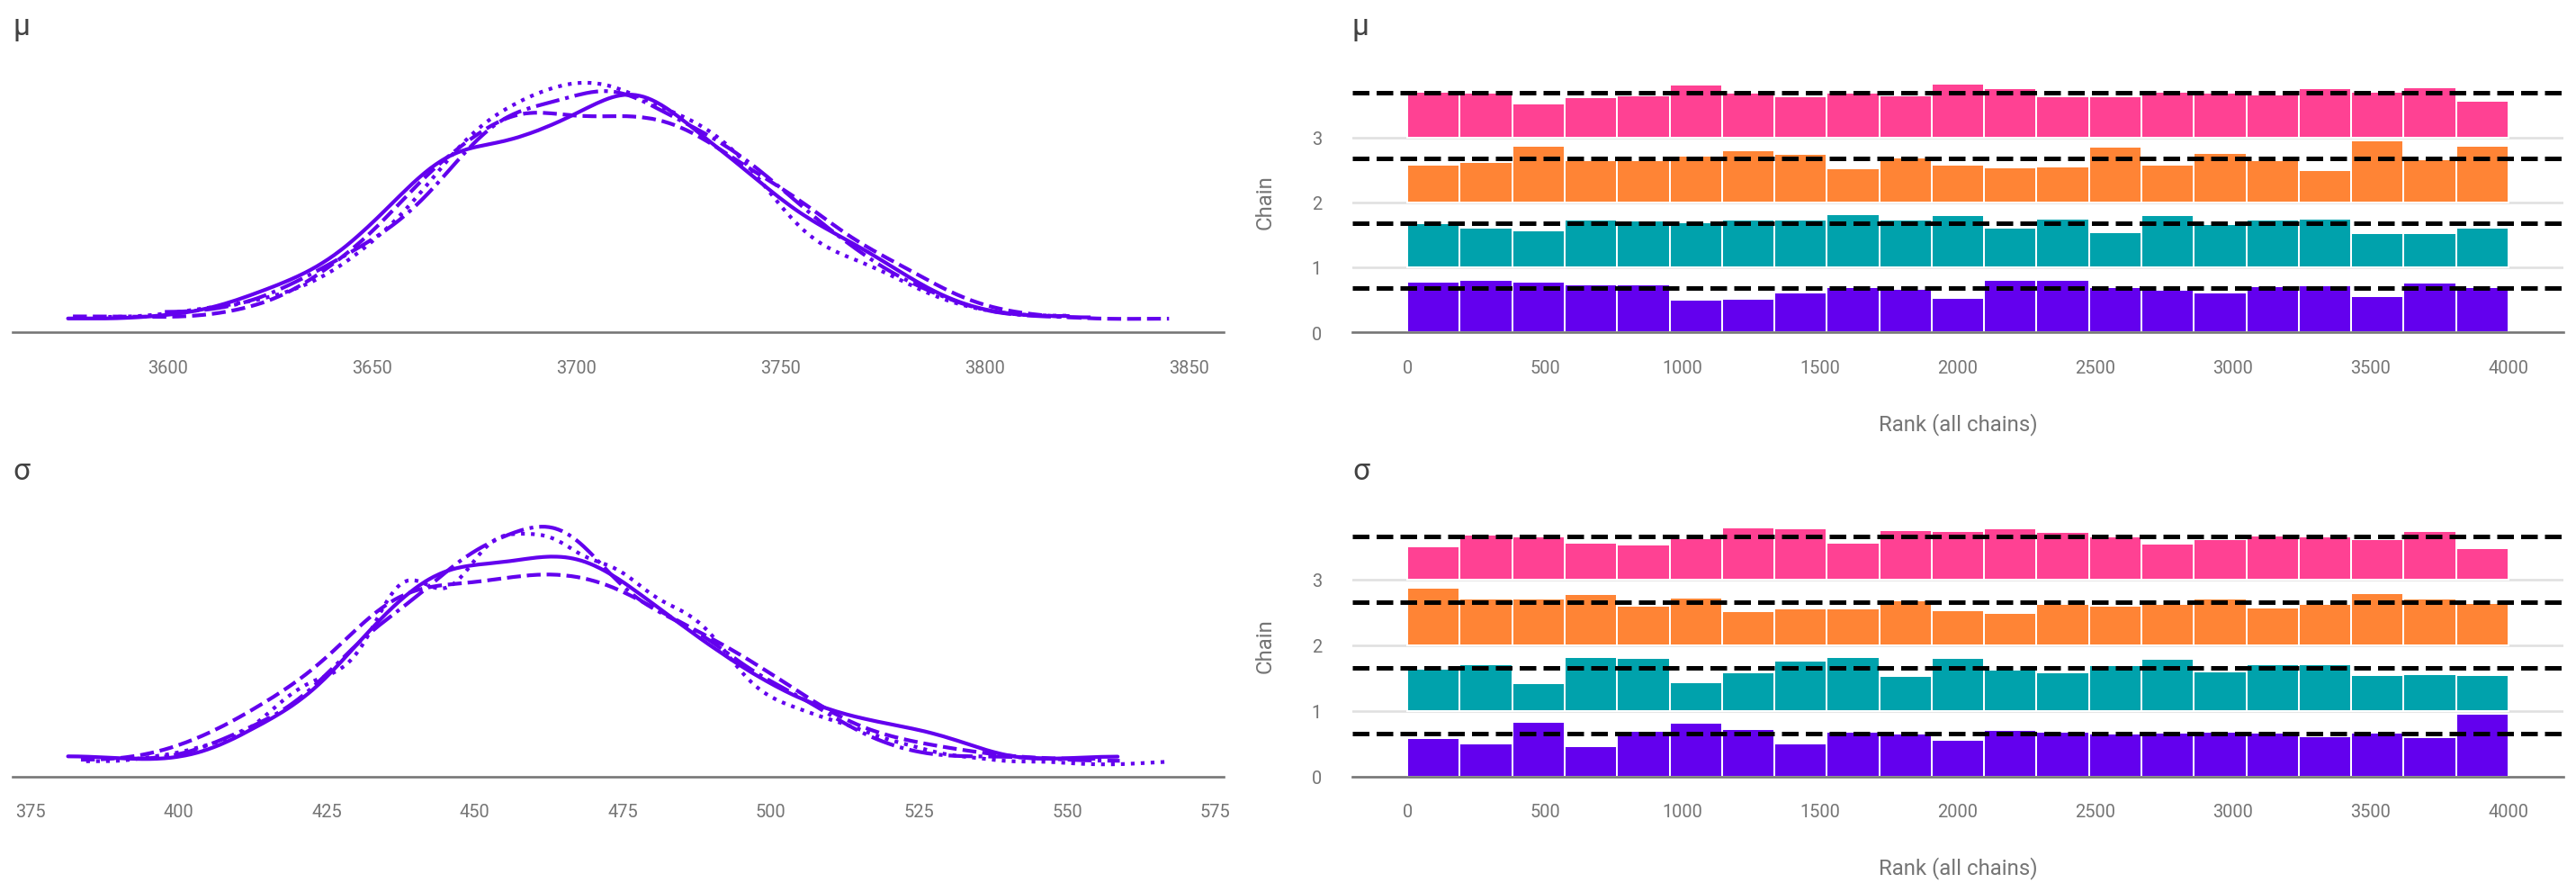

In [32]:
_, axes = plt.subplots(2, 2, figsize=(20, 7))
az.plot_trace(
    inf_data_adelie_penguin_mass, divergences="bottom", kind="rank_bars", axes=axes
)
plt.tight_layout();

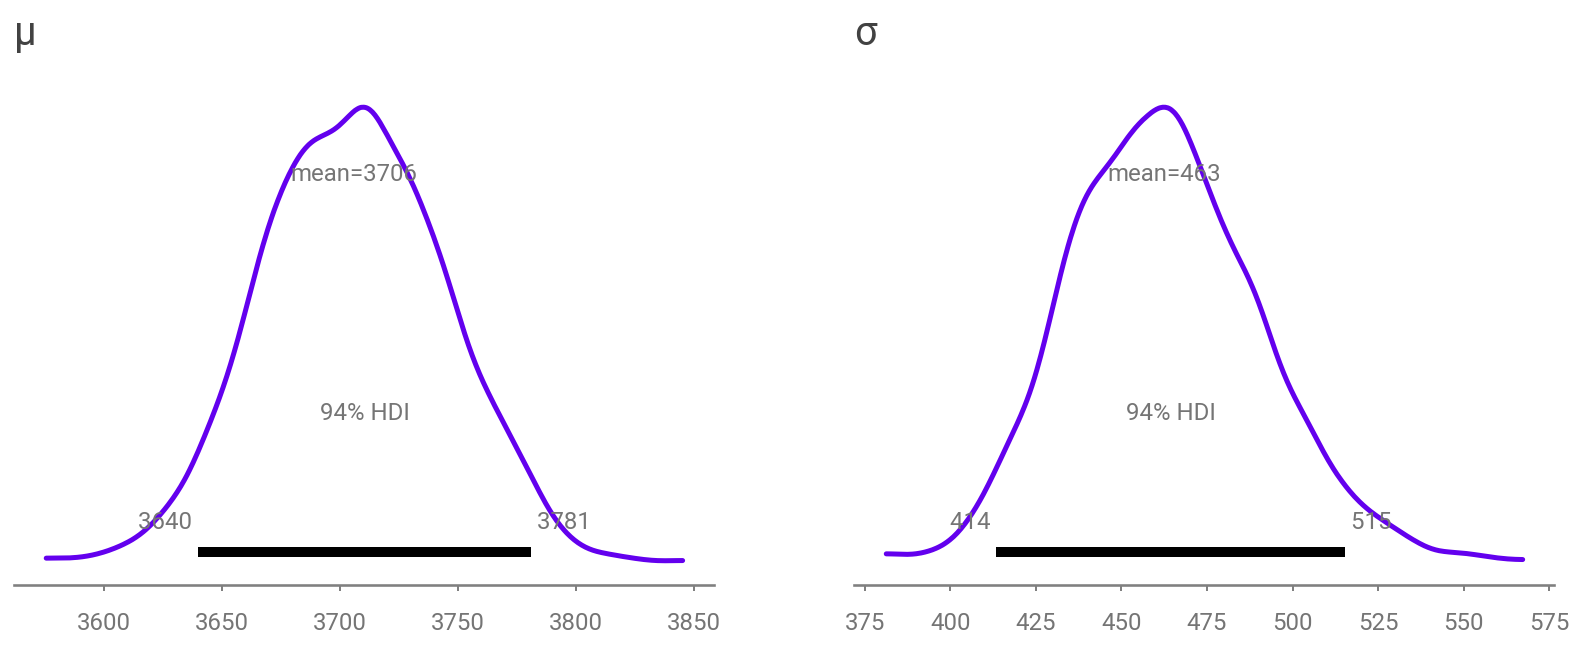

In [33]:
az.plot_posterior(inf_data_adelie_penguin_mass);

In [38]:
all_species = pd.Categorical(penguins["species"])
with pm.Model(
    coords={"species": all_species.categories}
) as model_penguin_mass_all_species:
    σ = pm.HalfStudentT("σ", 100, 2_000, dims="species")
    μ = pm.Normal("μ", 4_000, 3_000, dims="species")
    mass = pm.Normal(
        "mass",
        mu=μ[all_species.codes],
        sigma=σ[all_species.codes],
        observed=penguins["body_mass_g"],
    )
    trace = pm.sample()
    inf_data_model_penguin_mass_all_species = az.from_pymc3(trace=trace)

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


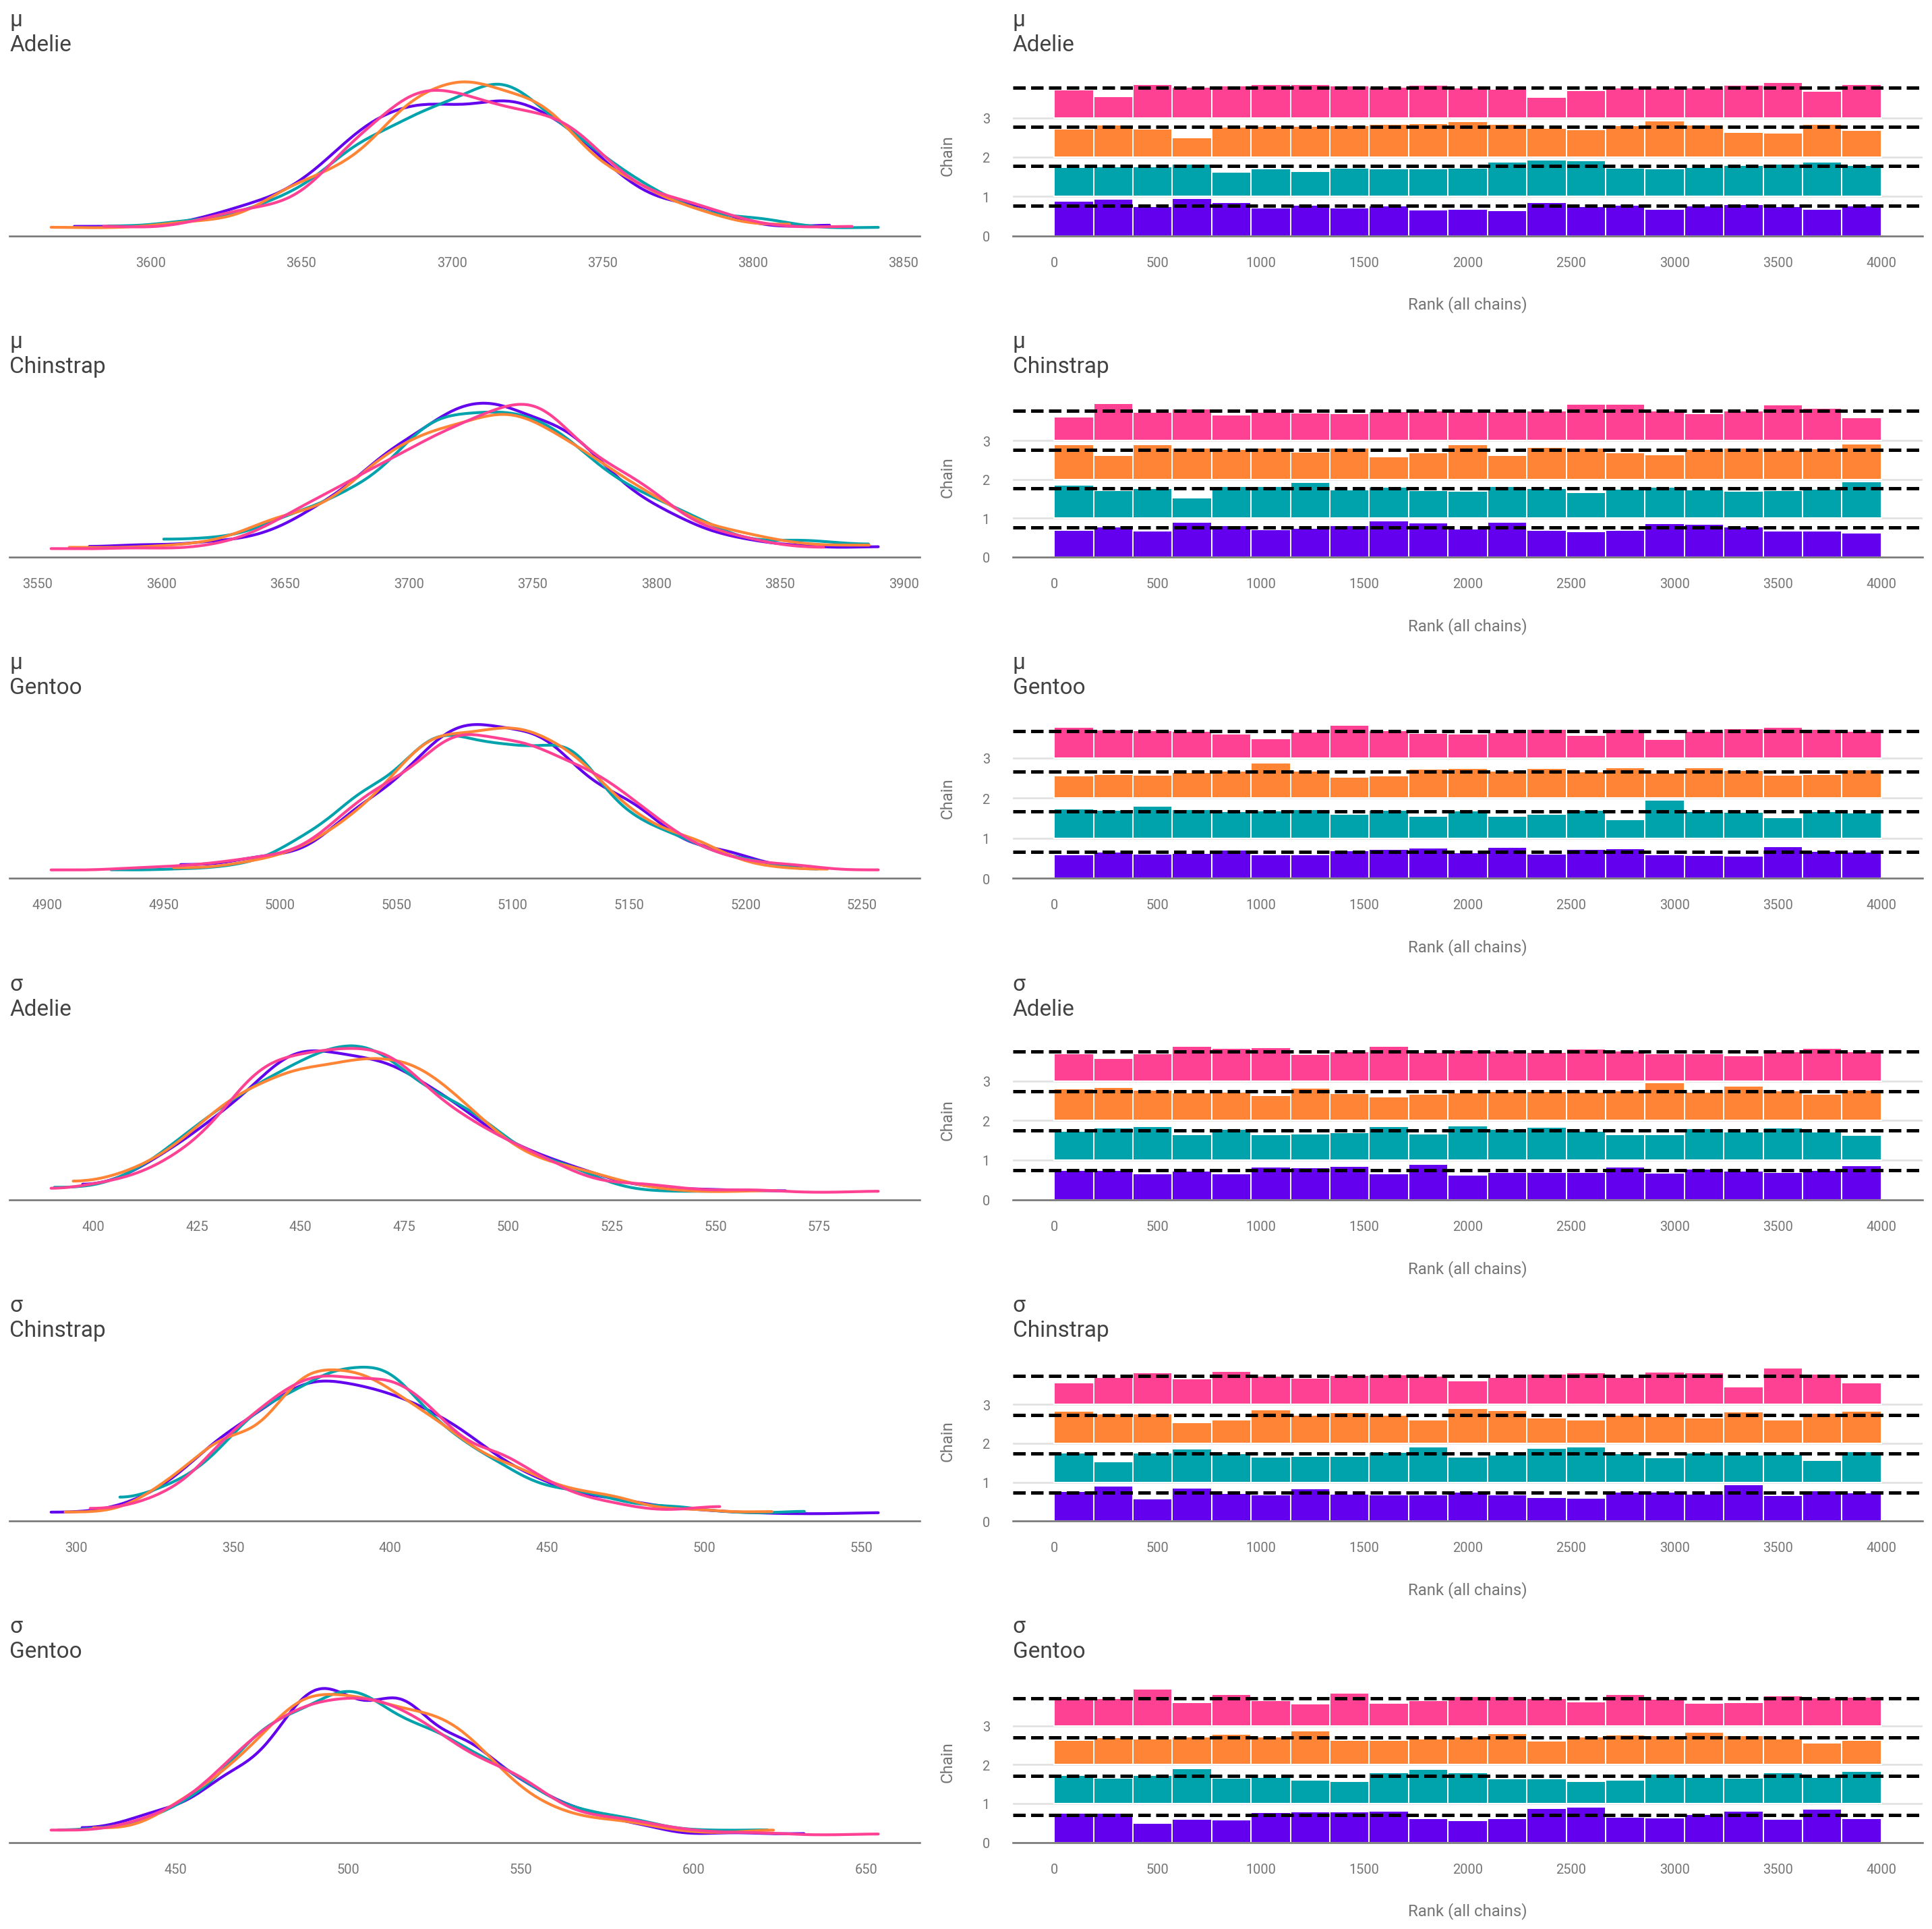

In [46]:
_, axes = plt.subplots(all_species.categories.shape[0] * 2, 2, figsize=(20, 20))
az.plot_trace(
    inf_data_model_penguin_mass_all_species,
    compact=False,
    divergences="bottom",
    kind="rank_bars",
    axes=axes,
)
plt.tight_layout();

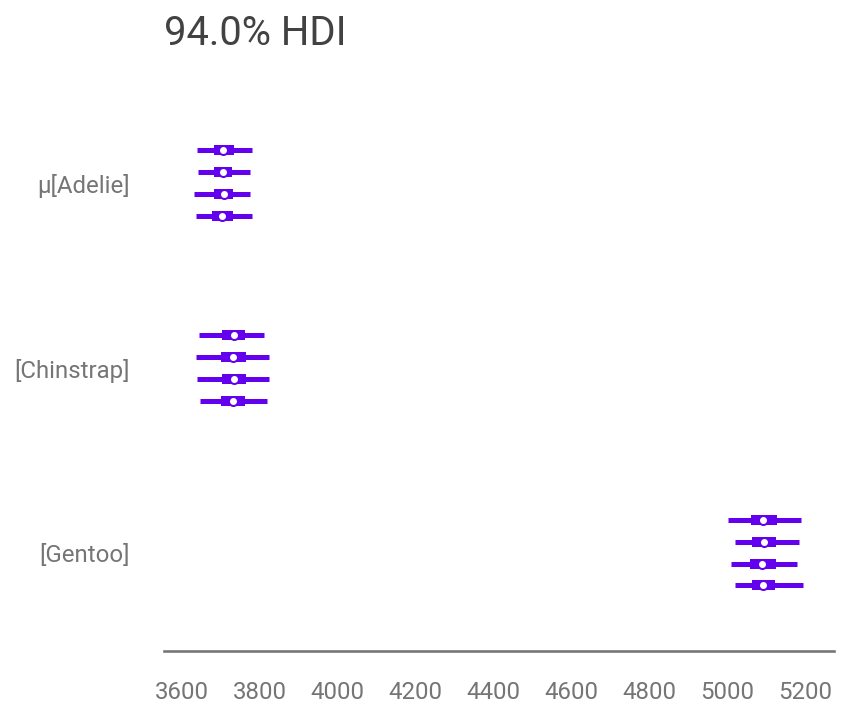

In [48]:
az.plot_forest(inf_data_model_penguin_mass_all_species, var_names=["μ"]);

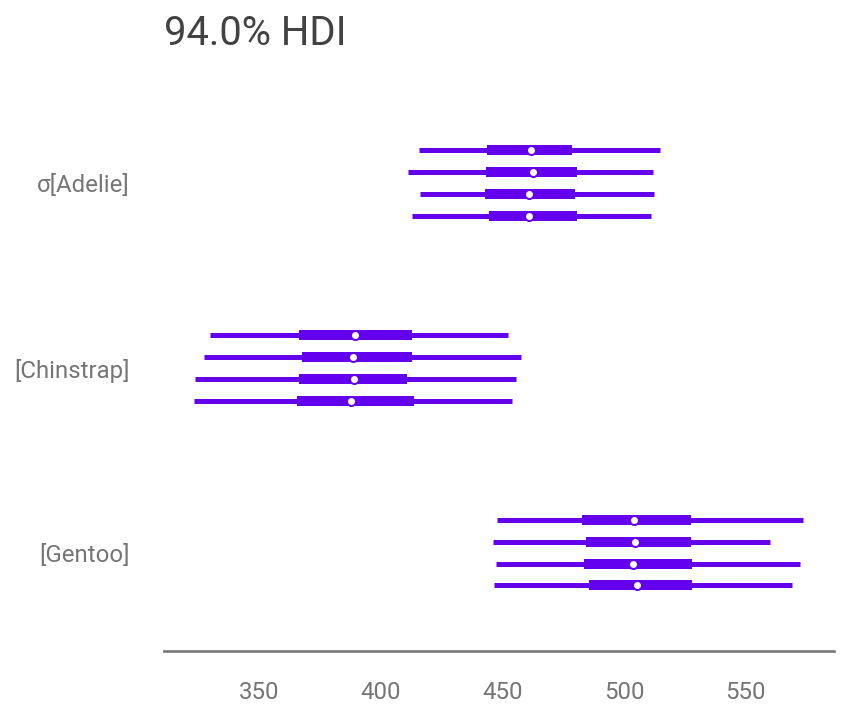

In [51]:
az.plot_forest(inf_data_model_penguin_mass_all_species, var_names=["σ"]);

### Comparing two PPLs

In [60]:
root = tfd.JointDistributionCoroutine.Root

species_idx = tf.constant(all_species.codes, tf.int32)
body_mass_g = tf.constant(penguins["body_mass_g"], tf.float32)

number_of_species = all_species.categories.shape[0]


@tfd.JointDistributionCoroutine
def jd_penguin_mass_all_species():
    σ = yield root(
        tfd.Sample(
            tfd.HalfStudentT(df=100, loc=0, scale=2_000),
            sample_shape=number_of_species,
            name="sigma",
        )
    )
    μ = yield root(
        tfd.Sample(
            tfd.Normal(loc=4_000, scale=3_000),
            sample_shape=number_of_species,
            name="mu",
        )
    )
    mass = yield tfd.Independent(
        tfd.Normal(
            loc=tf.gather(μ, species_idx, axis=-1),
            scale=tf.gather(σ, species_idx, axis=-1),
        ),
        reinterpreted_batch_ndims=1,
        name="mass",
    )

prior_predictive_samples = jd_penguin_mass_all_species.sample(1000)

`tfd.Independent` is used to indicate
that the distribution contains multiple copies
that we would like to sum over some axis—specified
by `reinterpreted_batch_ndims` arg—when
computing log-likelihood.

`.sample` can draw conditional samples.

In [61]:
jd_penguin_mass_all_species.sample(sigma=tf.constant([.1, .2, .3]))

StructTuple(
  sigma=<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.1, 0.2, 0.3], dtype=float32)>,
  mu=<tf.Tensor: shape=(3,), dtype=float32, numpy=array([10127.934 ,  1436.6582,  3898.2485], dtype=float32)>,
  mass=<tf.Tensor: shape=(333,), dtype=float32, numpy=
    array([10127.897 , 10128.058 , 10127.865 , 10127.869 , 10127.985 ,
           10127.765 , 10127.864 , 10127.876 , 10128.026 , 10127.856 ,
           10127.963 , 10127.851 , 10127.826 , 10127.94  , 10128.083 ,
           10128.066 , 10127.958 , 10127.886 , 10128.069 , 10127.839 ,
           10128.086 , 10127.942 , 10127.742 , 10127.914 , 10128.106 ,
           10127.864 , 10128.013 , 10127.823 , 10128.008 , 10128.019 ,
           10127.909 , 10127.994 , 10127.81  , 10127.816 , 10128.041 ,
           10127.937 , 10127.891 , 10127.929 , 10127.849 , 10127.978 ,
           10127.893 , 10127.906 , 10127.907 , 10128.087 , 10127.836 ,
           10127.888 , 10127.884 , 10127.937 , 10127.925 , 10128.038 ,
           10127.9

In [66]:
target_density_function = lambda *x: jd_penguin_mass_all_species.log_prob(
    *x, mass=body_mass_g
)

jd_penguin_mass_observed = jd_penguin_mass_all_species.experimental_pin(
    mass=body_mass_g
)
target_density_function = jd_penguin_mass_observed.unnormalized_log_prob

run_mcmc = tf.function(
    tfp.experimental.mcmc.windowed_adaptive_nuts, autograph=False, jit_compile=True
)
mcmc_samples, sampler_stats = run_mcmc(
    1_000,
    jd_penguin_mass_all_species,
    n_chains=4,
    num_adaptation_steps=1_000,
    mass=body_mass_g,
)
inf_data_model_penguin_mass_all_species2 = az.from_dict(
    posterior={
        # TFP mcmc returns (num_samples, num_chains, ...), we swap
        # the first and second axis below for each RV so the shape
        # is what ArviZ expected.
        k: np.swapaxes(v, 1, 0)
        for k, v in mcmc_samples._asdict().items()
    },
    sample_stats={
        k: np.swapaxes(sampler_stats[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]
    },
)

2022-05-09 21:26:17.724463: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert


In [67]:
prior_predictive_samples = jd_penguin_mass_all_species.sample([1, 1_000])
dist, samples = jd_penguin_mass_all_species.sample_distributions(value=mcmc_samples)
ppc_samples = samples[-1]
ppc_distribution = dist[-1].distribution
data_log_likelihood = ppc_distribution.log_prob(body_mass_g)

# Be careful not to run this code twice during REPL workflow.
inf_data_model_penguin_mass_all_species2.add_groups(
    prior=prior_predictive_samples[:-1]._asdict(),
    prior_predictive={"mass": prior_predictive_samples[-1]},
    posterior_predictive={"mass": np.swapaxes(ppc_samples, 1, 0)},
    log_likelihood={"mass": np.swapaxes(data_log_likelihood, 1, 0)},
    observed_data={"mass": body_mass_g},
)

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/arviz/data/inference_data.py:1372: UserWarning: the default dims 'chain' and 'draw' will be added automatically
  warnings.warn(
